# フーリエ変換による画像再構成でも

In [57]:
import numpy as np
import scipy as sp
from scipy.fft import fft2, ifft2
from matplotlib import cm
import matplotlib.pylab as plt
from PIL import Image


In [58]:
def scnline(r):
    '''r レベルのスキャンラインの生成'''
    ret = []
    for i in range(r + 1):
        ret.append((r - i, i))
    for i in range(1, r):
        ret.append((-i, r - i))
    return ret

def scnseq(n):
    '''n レベルまでのスキャン系列'''
    ret = []
    for i in range(n + 1):
        ret += scnline(i)
    return ret


def decompImgCoord(img, blksz=16):
    '''各少ブロックの左上の座標を返す'''
    startPnt = []
    Nh = img.shape[0]
    Nw = img.shape[1]
    for i in range(Nh // blksz):
        for j in range(Nw // blksz):
            startPnt.append((i * blksz, j * blksz))
    return startPnt


def blkiFFT(blkFFTimg, startPnts, blksz):
    '''各ブロックの画像を復元する'''
    blkifftimg = np.zeros(blkFFTimg.shape, dtype=complex)
    for b in startPnts:
        py, px = b[0], b[1]
        blkifftimg[py:py+blksz, px:px+blksz] = ifft2(blkFFTimg[py:py+blksz, px:px+blksz])
    return blkifftimg


def blkFFT(img, startPnts, blksz):
    '''各ブロックの画像をフーリエ変換する'''
    blkfftimg = np.zeros(img.shape, dtype=complex)
    for b in startPnts:
        py, px = b[0], b[1]
        blkfftimg[py:py+blksz, px:px+blksz] = fft2(img[py:py+blksz, px:px+blksz])
    return blkfftimg


def blkFilter(blkFFTimg, flt, startPnts, blksz):
    filterimg = np.zeros(blkFFTimg.shape, dtype=complex)
    for b in startPnts:
        py, px = b[0], b[1]
        filterimg[py:py+blksz, px:px+blksz] = (blkFFTimg[py:py+blksz, px:px+blksz] * flt)
    return filterimg



Total CoverRate 0.16796875


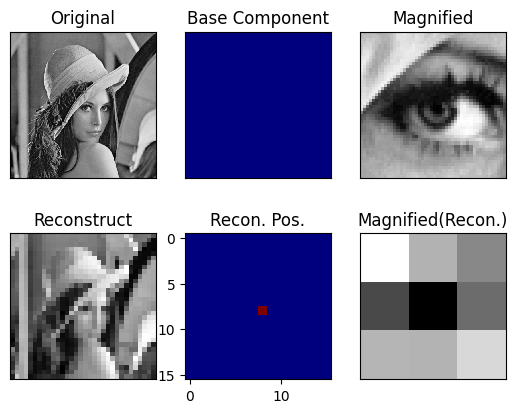

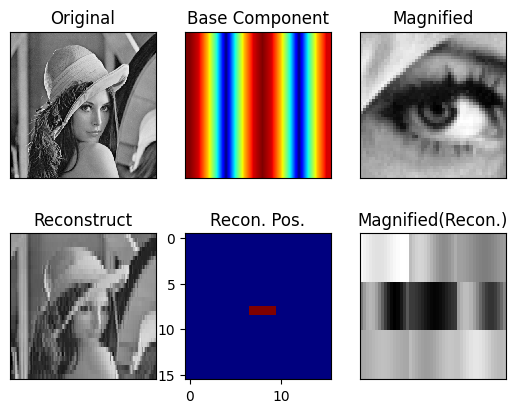

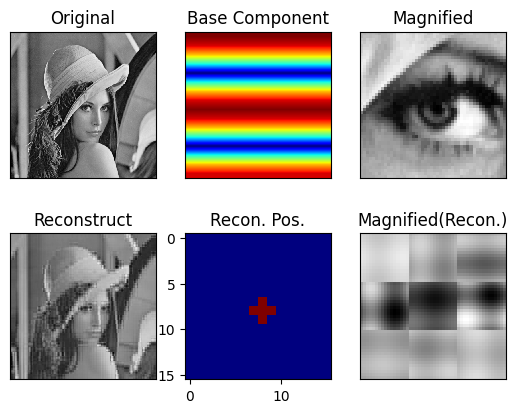

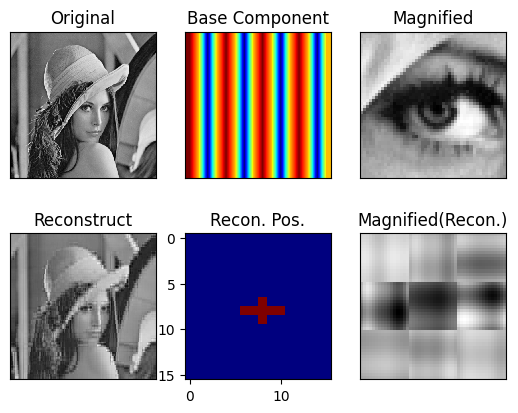

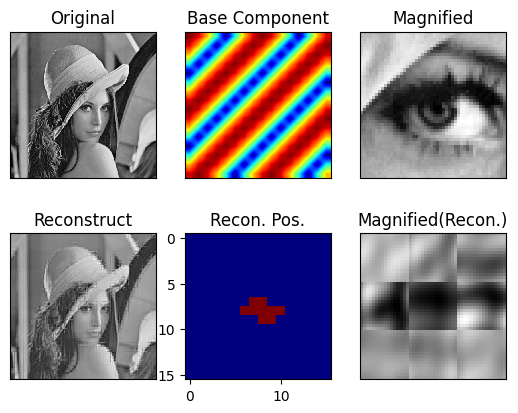

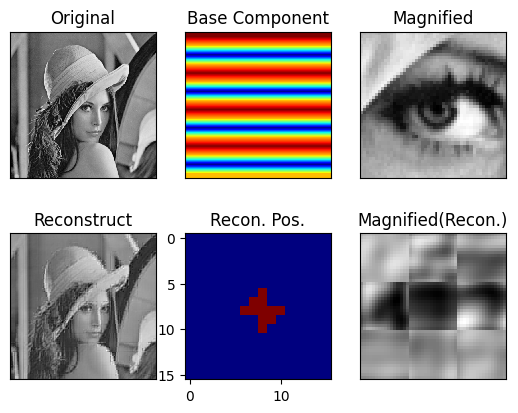

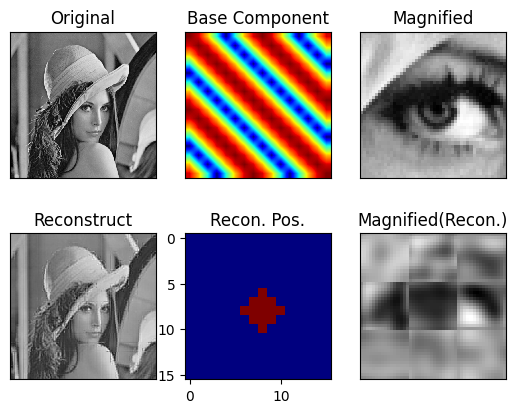

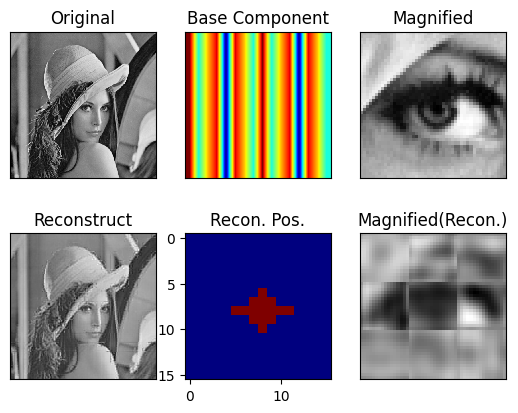

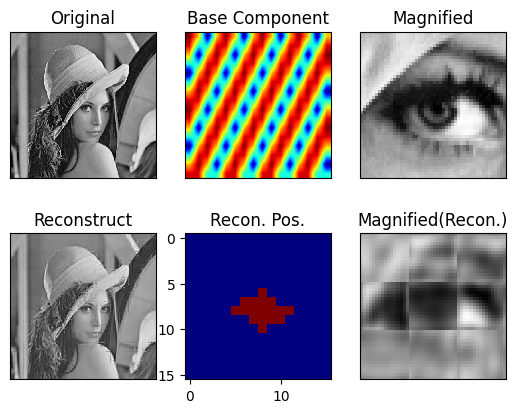

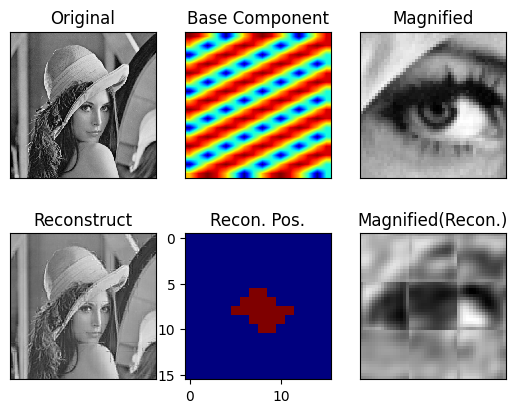

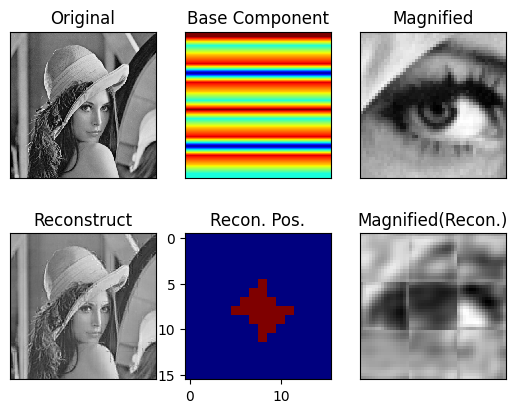

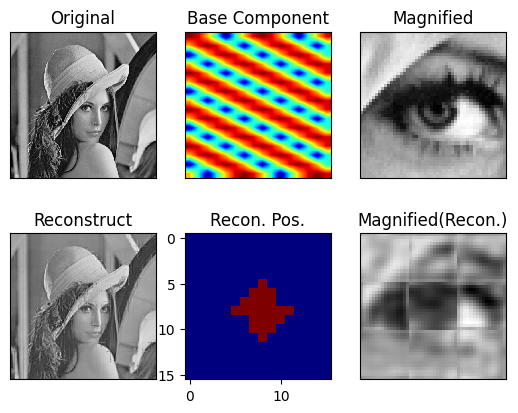

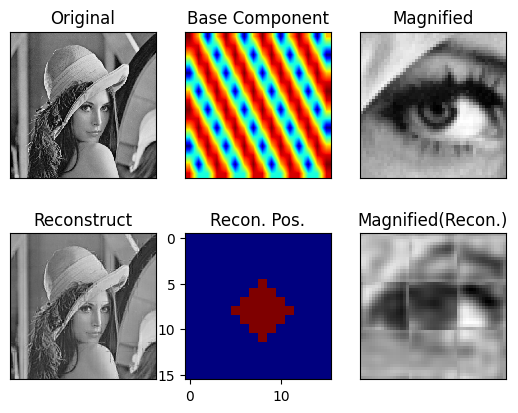

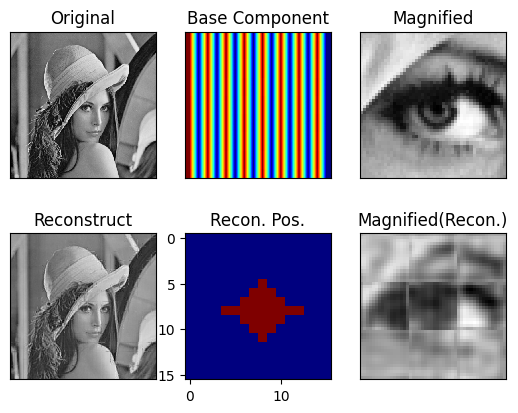

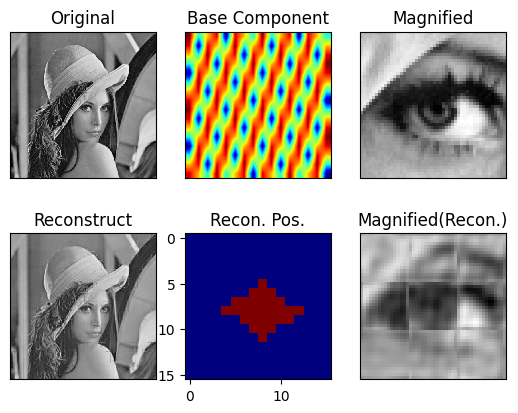

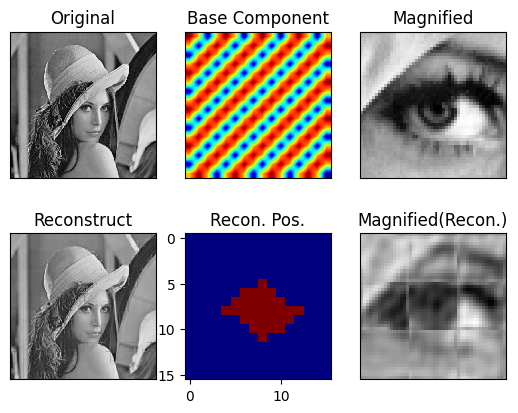

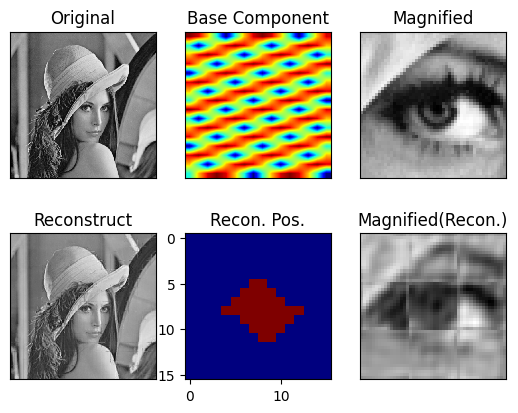

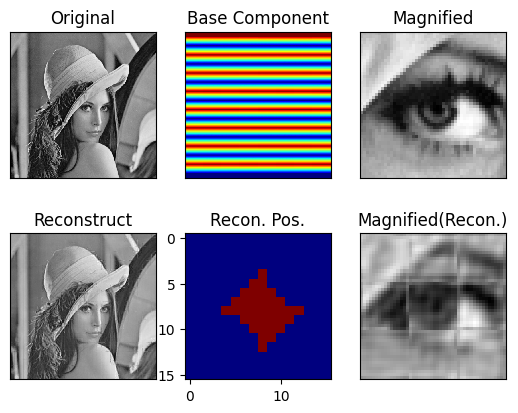

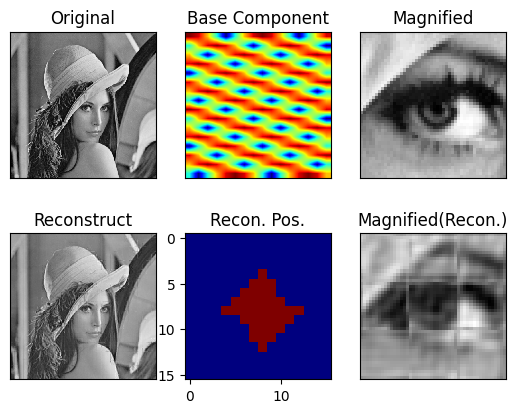

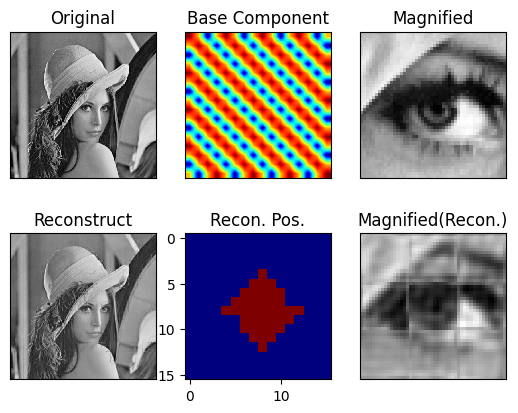

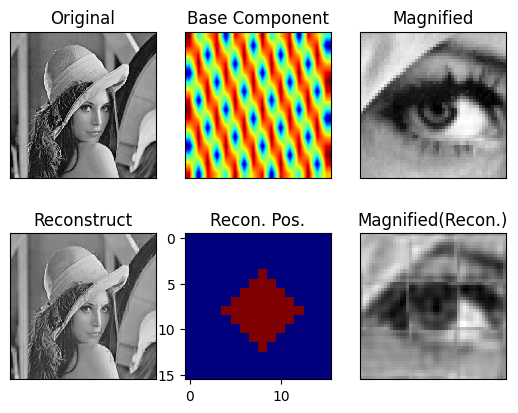

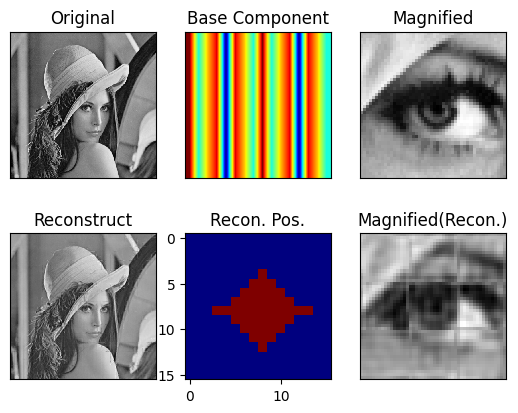

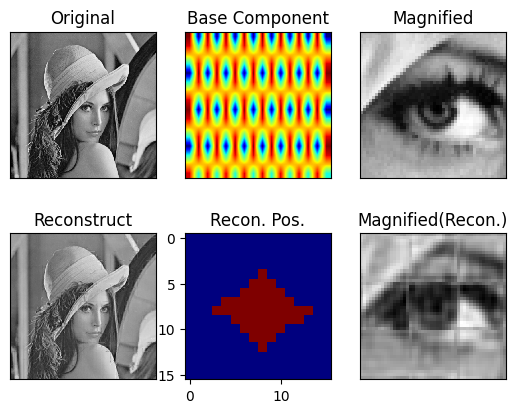

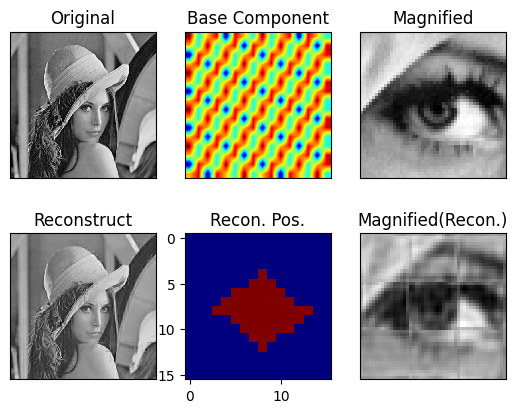

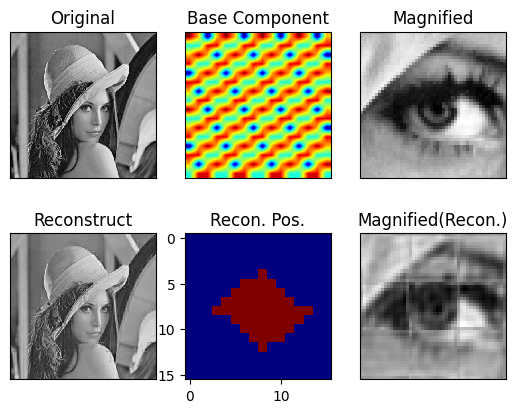

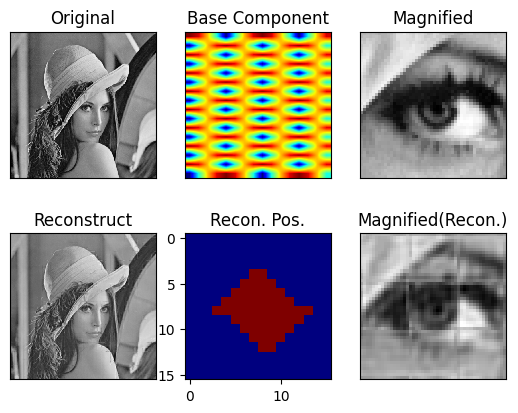

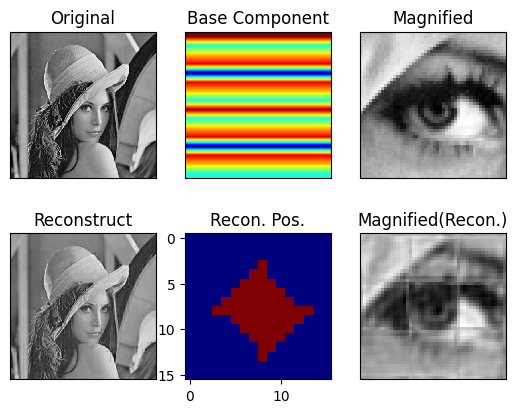

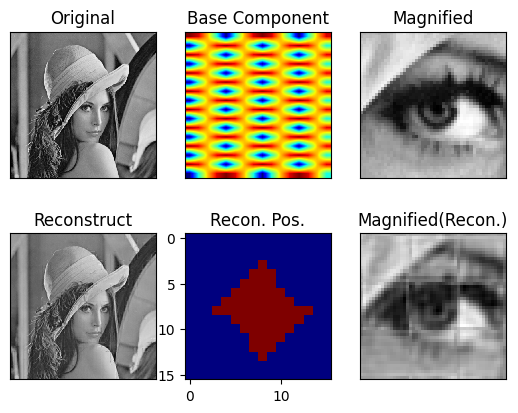

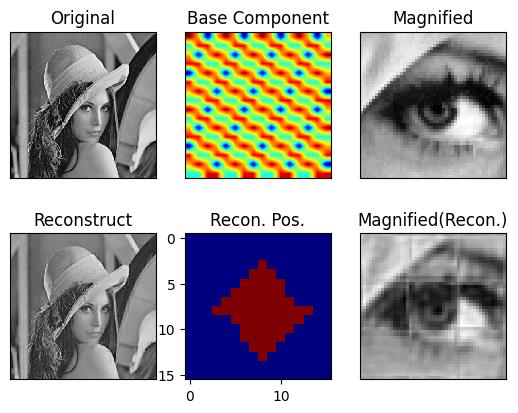

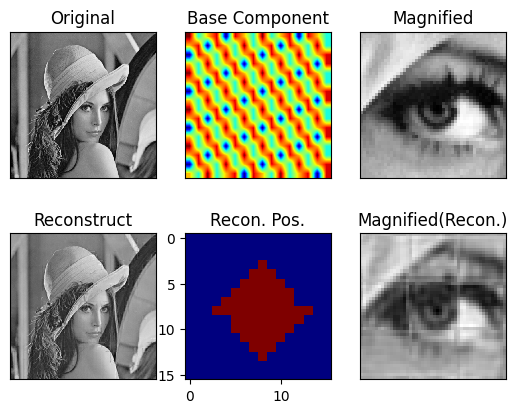

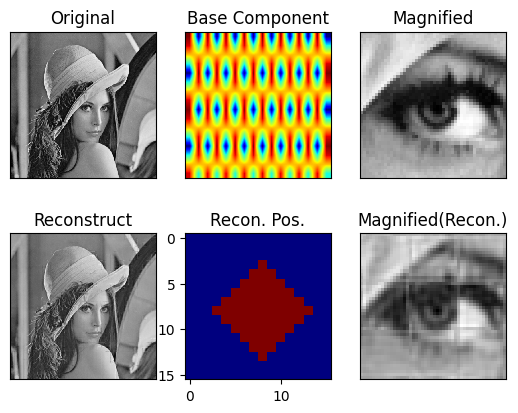

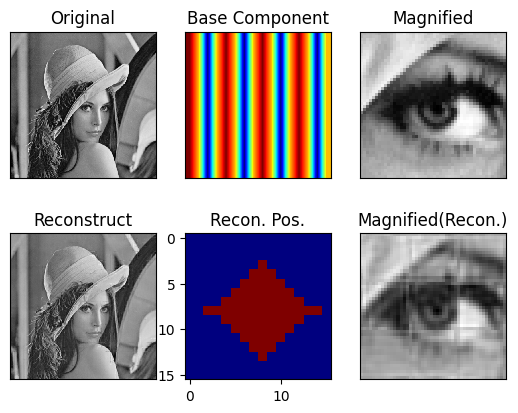

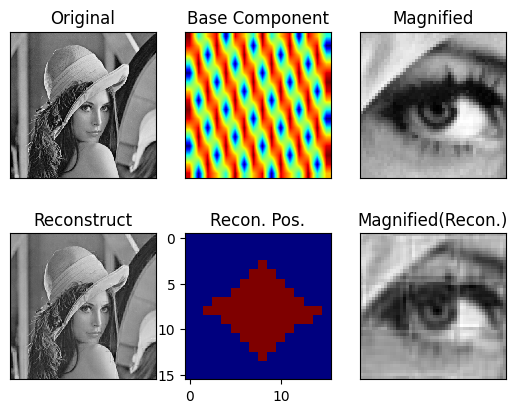

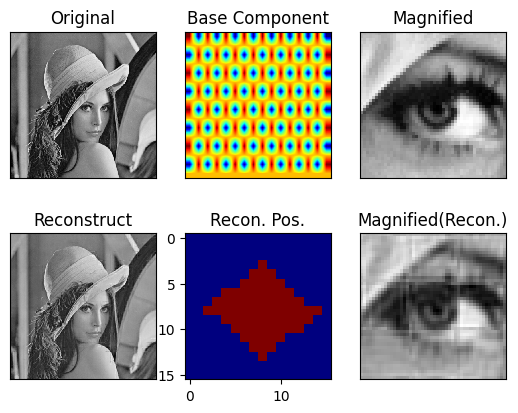

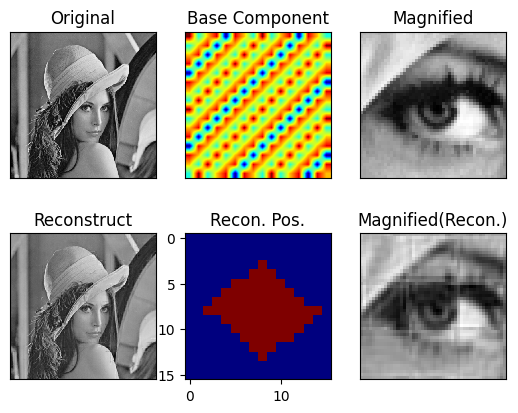

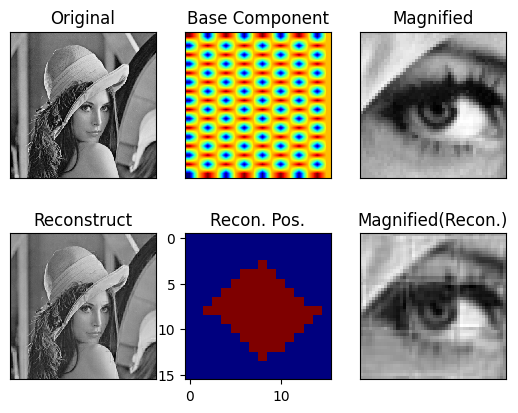

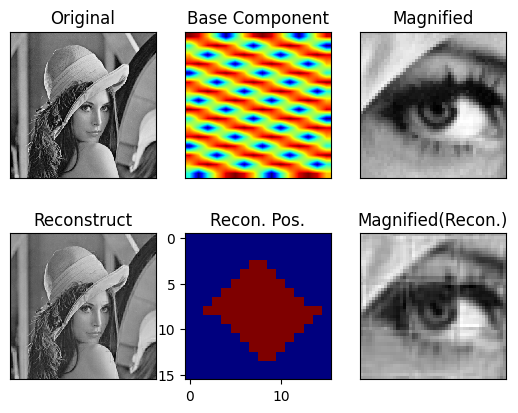

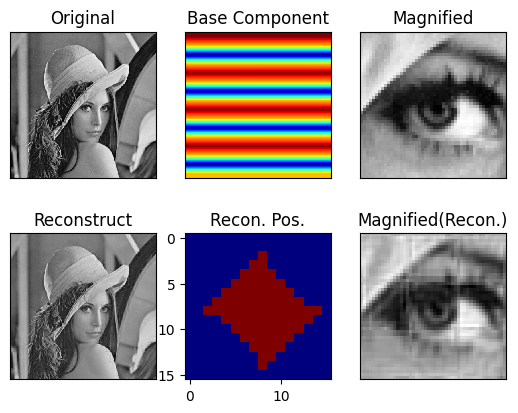

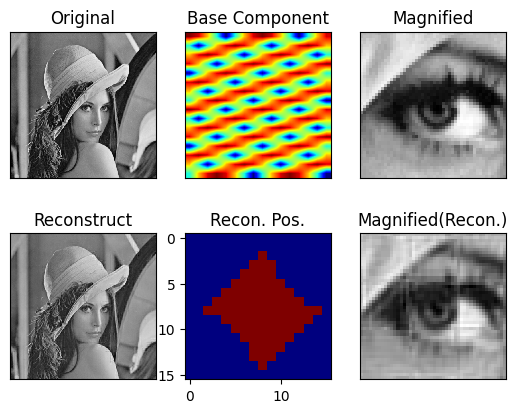

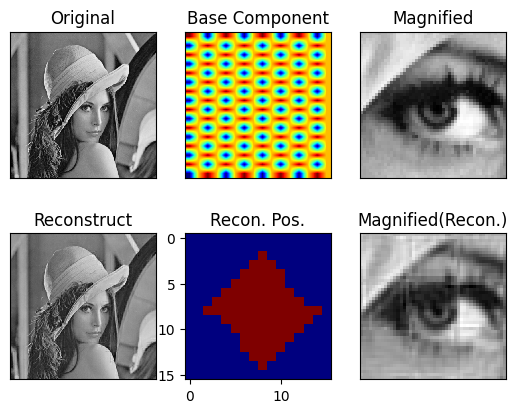

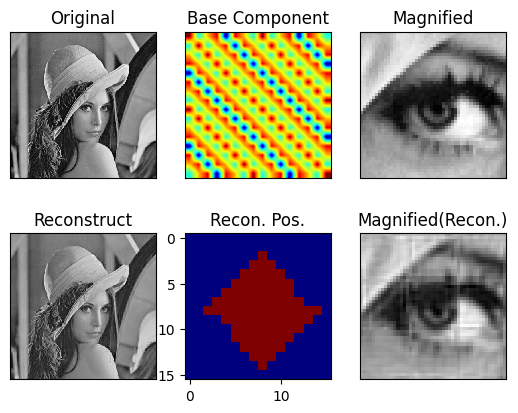

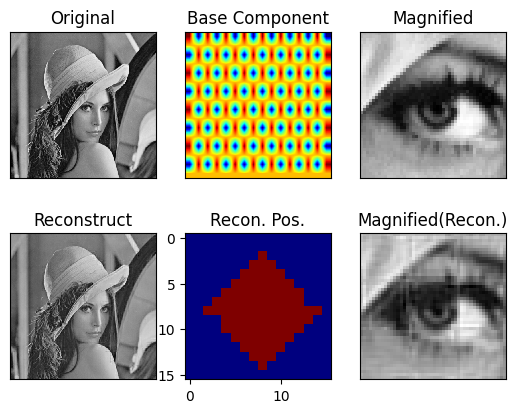

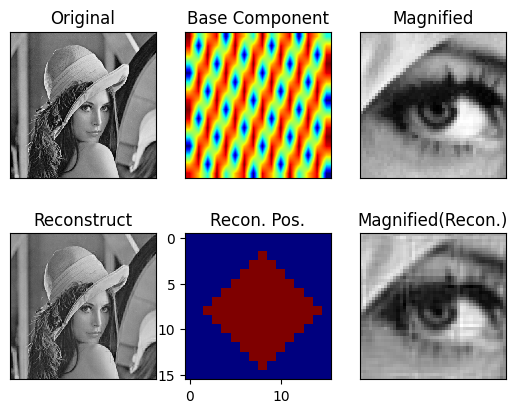

In [59]:

img = Image.open("../test_images/lena.png")
img_ary = np.asarray(img)

# blksz = 32
blksz = 16
# blksz = 8

blkPnts = decompImgCoord(img_ary, blksz=blksz)
blkFFTimg = blkFFT(img_ary, blkPnts, blksz)

flt = np.zeros((blksz, blksz))
RecRange = 6
RecSeq = scnseq(RecRange)

print("Total CoverRate", len(RecSeq) / (blksz**2))

for p in RecSeq:
    plt.clf()
    plt.subplot(2, 3, 1)
    plt.imshow(img, interpolation="nearest")
    plt.title("Original")
    plt.gray()
    plt.xticks(())
    plt.yticks(())

    ppx, ppy = p[0], p[1]

    cur = np.zeros((blksz, blksz))
    cur[ppy, ppx] = 1
    cur[-ppy, -ppx] = 1

    plt.subplot(2, 3, 2)
    base_img = np.abs(ifft2(cur))
    plt.imshow(base_img, cmap='jet', interpolation='bilinear')
    plt.xticks(())
    plt.yticks(())
    plt.title("Base Component")

    #    nblk = 4
    nblk = 3
    #    xoff, yoff = 7, 7
    xoff, yoff = 15, 15
    plt.subplot(2, 3, 3)
    rrr = (yoff * blksz, (yoff + nblk) * blksz, xoff * blksz, (xoff + nblk) * blksz)
    plt.imshow(img_ary[rrr[0]:rrr[1], rrr[2]:rrr[3]], cmap=cm.gray)
    plt.xticks(())
    plt.yticks(())
    plt.title("Magnified")

    plt.subplot(2, 3, 4)
    flt[ppy, ppx] = 1
    flt[-ppy, -ppx] = 1

    fblkFFTimg = blkFilter(blkFFTimg, flt, blkPnts, blksz)
    recimg = blkiFFT(fblkFFTimg, blkPnts, blksz).real

    plt.imshow(recimg, interpolation="nearest")
    plt.gray()
    plt.xticks(())
    plt.yticks(())
    plt.title("Reconstruct")

    plt.subplot(2, 3, 5)
    plt.imshow(np.fft.fftshift(flt), interpolation="nearest", cmap='jet')
    plt.title("Recon. Pos.")


    plt.subplot(2, 3, 6)
    plt.imshow(recimg[rrr[0] : rrr[1], rrr[2] : rrr[3]], cmap=cm.gray, interpolation="nearest")
    plt.xticks(())
    plt.yticks(())
    plt.title("Magnified(Recon.)")

    plt.pause(0.5)


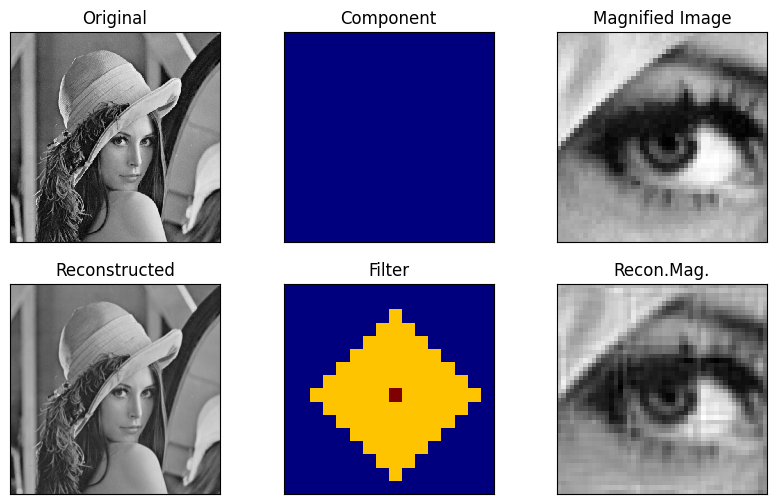

In [61]:
import numpy as np
import scipy as sp
from scipy.fft import ifft2, fftshift
import matplotlib.pylab as plt
from matplotlib.animation import FuncAnimation

def update(f, axs, img, blkFFTimg, blksz, ReqSeq, nblk, offset, flt):
    '''f はフレーム番号，axs は Axes オブジェクトのリスト'''
    for ax in axs:
        ax.cla()
        ax.set_xticks(())
        ax.set_yticks(())
    axs[0].set_title('Original')
    axs[1].set_title('Component')
    axs[2].set_title('Magnified Image')
    axs[3].set_title('Reconstructed')
    axs[4].set_title('Filter')
    axs[5].set_title('Recon.Mag.')

    # 原画像の表示 in ax[0]
    axs[0].imshow(img, interpolation="nearest", cmap='gray')
    
    # 基底の表示 in ax[1]
    p = ReqSeq[f]
    cur = np.zeros((blksz, blksz), dtype=complex)
    cur[p[0],  p[1]] = 1
    cur[-p[0], -p[1]] = 1
    base_img = np.abs(ifft2(cur))
    axs[1].imshow(base_img, cmap='jet', interpolation='bilinear')
    
    # 拡大画像の表示 in ax[2]
    # 拡大して表示するブロックの個数 nblk x nblk を表示
    # offset は，どこを表示するかのオフセット y 方向，x 方向の順
    yoff, xoff = offset[0], offset[1]
    top, bottom = yoff * blksz, (yoff + nblk) * blksz
    left, right = xoff * blksz, (xoff + nblk) * blksz
    axs[2].imshow(img[top:bottom, left:right], cmap=cm.gray)
    
    # フィルタの表示 in ax[4] 都合によりこっちを先に処理
    axs[4].imshow(fftshift(np.abs(flt*0.7+cur)), cmap='jet', vmin=0, vmax=1)
    # 表示後フィルタを cur の位置のフィルタ値を更新しておく
    flt[p[0], p[1]] = 1
    flt[-p[0], -p[1]] = 1  
    
    # フィルタをかけた画像の表示 in ax[3]
    fblkFFTimg = blkFilter(blkFFTimg, flt, blkPnts, blksz)
    recimg = blkiFFT(fblkFFTimg, blkPnts, blksz).real
    axs[3].imshow(recimg, cmap='gray')
    
    # フィルタをかけた画像の拡大表示 in ax[5]
    axs[5].imshow(recimg[top:bottom, left:right], cmap=cm.gray)


fig, axs = plt.subplots(2, 3, figsize=(10, 6))
axs = axs.flatten()

img = Image.open("../test_images/lena.png")
img_ary = np.asarray(img)

# blksz = 8
blksz = 16
# blksz = 32

blkPnts = decompImgCoord(img_ary, blksz=blksz)
blkFFTimg = blkFFT(img_ary, blkPnts, blksz)

flt = np.zeros((blksz, blksz))
RecRange = 6
RecSeq = scnseq(RecRange)

# 目の位置を拡大中心にするためのパラメータ
# nblk がブロック数，xoff, yoff がオフセット
nblk = 3
xoff, yoff = 15, 15


#for i in range(10):
#   update(i, axs, img_ary, blkFFTimg, blksz, RecSeq, nblk, (yoff, xoff), flt)


anim = FuncAnimation(fig, update, frames=len(RecSeq),
                     fargs=(axs, img_ary, blkFFTimg, blksz, RecSeq, nblk, (yoff, xoff), flt), 
                     interval=500)
anim.save('TmpImages/img_reconstdemo.mp4', writer='ffmpeg')




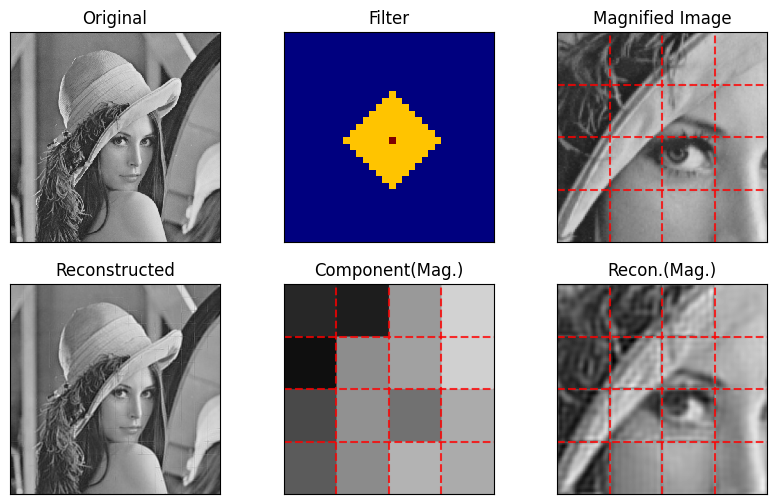

In [71]:
import numpy as np
import scipy as sp
from scipy.fft import ifft2, fftshift
import matplotlib.pylab as plt
from matplotlib.animation import FuncAnimation

def update(f, axs, img, blkFFTimg, blksz, ReqSeq, nblk, offset, flt):
    '''f はフレーム番号，axs は Axes オブジェクトのリスト'''
    for ax in axs:
        ax.cla()
        ax.set_xticks(())
        ax.set_yticks(())
    axs[0].set_title('Original')
    axs[1].set_title('Filter')
    axs[2].set_title('Magnified Image')
    axs[3].set_title('Reconstructed')
    axs[4].set_title('Component(Mag.)')
    axs[5].set_title('Recon.(Mag.)')

    # 原画像の表示 in ax[0]
    axs[0].imshow(img, interpolation="nearest", cmap='gray', vmin=0, vmax=1)
    
    # フィルタの表示 in ax[1]
    p = ReqSeq[f]
    cur = np.zeros((blksz, blksz), dtype=complex)
    cur[p[0],  p[1]] = 1
    cur[-p[0], -p[1]] = 1
    axs[1].imshow(fftshift(np.abs(flt*0.7+cur)), cmap='jet', vmin=0, vmax=1)
    # 表示後フィルタを cur の位置のフィルタ値を更新しておく
    flt[p[0], p[1]] = 1
    flt[-p[0], -p[1]] = 1  
    
    # 拡大画像の表示 in ax[2]
    # 拡大して表示するブロックの個数 nblk x nblk を表示
    # offset は，どこを表示するかのオフセット y 方向，x 方向の順
    yoff, xoff = offset[0], offset[1]
    top, bottom = yoff * blksz, (yoff + nblk) * blksz
    left, right = xoff * blksz, (xoff + nblk) * blksz
    axs[2].imshow(img[top:bottom, left:right], cmap='gray', vmin=0, vmax=1)

    # フィルタをかけた画像の表示 in ax[3]
    fblkFFTimg = blkFilter(blkFFTimg, flt, blkPnts, blksz)
    recimg = blkiFFT(fblkFFTimg, blkPnts, blksz).real
    axs[3].imshow(recimg, cmap='gray', vmin=0, vmax=1)

    # 基底の表示 in ax[4] cur をフィルタにすれば良い
    fblkFFTimg_base = blkFilter(blkFFTimg, cur, blkPnts, blksz)
    img_base = blkiFFT(fblkFFTimg_base, blkPnts, blksz).real
    img_max, img_min = np.max(img_base), np.min(img_base)
    axs[4].imshow(img_base[top:bottom, left:right], cmap='gray', vmin=img_min, vmax=img_max)

    
    # フィルタをかけた画像の拡大表示 in ax[5]
    axs[5].imshow(recimg[top:bottom, left:right], cmap=cm.gray, vmin=0, vmax=1)

    for ax_id in (2, 4, 5):
        for n in range(1, nblk):
            axs[ax_id].axhline(y=n*blksz-0.5, color='r', linestyle='dashed', alpha=0.8)
            axs[ax_id].axvline(x=n*blksz-0.5, color='r', linestyle='dashed', alpha=0.8)





fig, axs = plt.subplots(2, 3, figsize=(10, 6))
axs = axs.flatten()

img = Image.open("../test_images/lena.png")
img_ary = np.asarray(img)/255.0

# blksz = 8
#blksz = 16
blksz = 32

blkPnts = decompImgCoord(img_ary, blksz=blksz)
blkFFTimg = blkFFT(img_ary, blkPnts, blksz)

flt = np.zeros((blksz, blksz))
#RecRange = 6
RecRange = 7
RecSeq = scnseq(RecRange)

# 目の位置を拡大中心にするためのパラメータ
# nblk がブロック数，xoff, yoff がオフセット
#nblk = 3
nblk = 4
#xoff, yoff = 15, 15
xoff, yoff = 6, 6


#for i in range(10):
#   update(i, axs, img_ary, blkFFTimg, blksz, RecSeq, nblk, (yoff, xoff), flt)


anim = FuncAnimation(fig, update, frames=len(RecSeq),
                     fargs=(axs, img_ary, blkFFTimg, blksz, RecSeq, nblk, (yoff, xoff), flt), 
                     interval=500)
anim.save('TmpImages/img_reconstdemo2.mp4', writer='ffmpeg')



In [66]:
def scnline(r):
    '''r レベルのスキャンラインの生成'''
    ret = []
    for i in range(r + 1):
        ret.append((r - i, i))
#        ret.append((-r + i, -i))
    for i in range(1, r):
        ret.append((-i, r - i))
#        ret.append((i, -r + i))
    return ret

print(scnline(6))

[(6, 0), (5, 1), (4, 2), (3, 3), (2, 4), (1, 5), (0, 6), (-1, 5), (-2, 4), (-3, 3), (-4, 2), (-5, 1)]


In [67]:
print(RecSeq)

[(0, 0), (1, 0), (0, 1), (2, 0), (1, 1), (0, 2), (-1, 1), (3, 0), (2, 1), (1, 2), (0, 3), (-1, 2), (-2, 1), (4, 0), (3, 1), (2, 2), (1, 3), (0, 4), (-1, 3), (-2, 2), (-3, 1), (5, 0), (4, 1), (3, 2), (2, 3), (1, 4), (0, 5), (-1, 4), (-2, 3), (-3, 2), (-4, 1), (6, 0), (5, 1), (4, 2), (3, 3), (2, 4), (1, 5), (0, 6), (-1, 5), (-2, 4), (-3, 3), (-4, 2), (-5, 1)]
